In [1]:
import sys
import xarray as xr
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
import importlib as imp
import json

import data_loader.data_loader as data_loader
from trainer.trainer import Trainer
from model.model import TorchModel
from utils import utils
import model.loss as module_loss
import model.metric as module_metric
import warnings

warnings.filterwarnings("ignore")
torch.set_warn_always(False)

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

# https://github.com/victoresque/pytorch-template/tree/master

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.26.3
xarray version = 2024.1.1
pytorch version = 2.1.0


In [2]:
config = utils.get_config("exp_test")

In [3]:
torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
torch.backends.cudnn.deterministic = True

# Setup the Data
trainset = data_loader.CustomData(
    config["data_loader"]["data_dir"] + "train_data.pickle"
)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "val_data.pickle")
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=True,
    drop_last=False,
)
val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=config["data_loader"]["batch_size"],
    shuffle=False,
    drop_last=False,
)

# Setup the Model
model = TorchModel(config=config["arch"], target=trainset.target)
model.freeze_layers(freeze_id="tau")
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(module_loss, config["criterion"])()
metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

# Build the trainer
device = utils.prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data_loader=train_loader,
    validation_data_loader=val_loader,
    device=device,
    config=config,
)

# Visualize the model
torchinfo.summary(
    model,
    [
        trainset.input[: config["data_loader"]["batch_size"]].shape,
        trainset.input_unit[: config["data_loader"]["batch_size"]].shape,
    ],
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

# Train the Model
model.to(device)
trainer.fit()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorchModel                               [32, 1, 72, 144]          [32, 4]                   --
├─CircularPad2d: 1-1                     [32, 1, 72, 144]          [32, 1, 72, 154]          --
├─Sequential: 1-2                        [32, 1, 72, 154]          [32, 32, 9, 20]           --
│    └─Sequential: 2-1                   [32, 1, 72, 154]          [32, 32, 36, 77]          --
│    │    └─Conv2d: 3-1                  [32, 1, 72, 154]          [32, 32, 72, 154]         832
│    │    └─ReLU: 3-2                    [32, 32, 72, 154]         [32, 32, 72, 154]         --
│    │    └─MaxPool2d: 3-3               [32, 32, 72, 154]         [32, 32, 36, 77]          --
│    └─Sequential: 2-2                   [32, 32, 36, 77]          [32, 32, 18, 39]          --
│    │    └─Conv2d: 3-4                  [32, 32, 36, 77]          [32, 32, 36, 77]          9,248
│    │    └─ReLU: 3-5          

dict_keys(['epoch', 'loss', 'val_loss', 'custom_mae', 'iqr_capture', 'sign_test', 'val_custom_mae', 'val_iqr_capture', 'val_sign_test'])


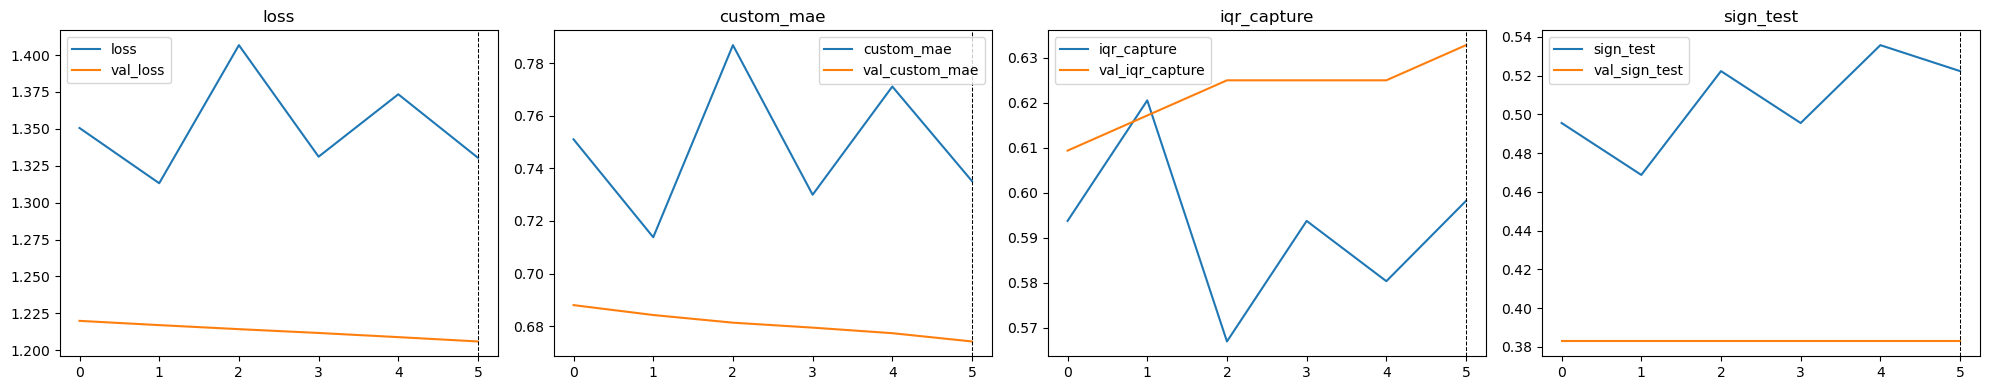

In [4]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
        x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

In [5]:
model.eval()
with torch.inference_mode():
    output = model.predict(dataset=valset, batch_size=128, device=device)
output[:7]

array([[ 0.9562179 ,  0.959541  , -0.20982242,  1.        ],
       [ 0.95078385,  0.9589479 , -0.20792784,  1.        ],
       [ 0.95469564,  0.9591974 , -0.20702186,  1.        ],
       [ 0.95553225,  0.9598734 , -0.2052344 ,  1.        ],
       [ 0.95471174,  0.96105665, -0.20223893,  1.        ],
       [ 0.9508055 ,  0.95923334, -0.2012622 ,  1.        ],
       [ 0.9503152 ,  0.95878106, -0.20058706,  1.        ]],
      dtype=float32)

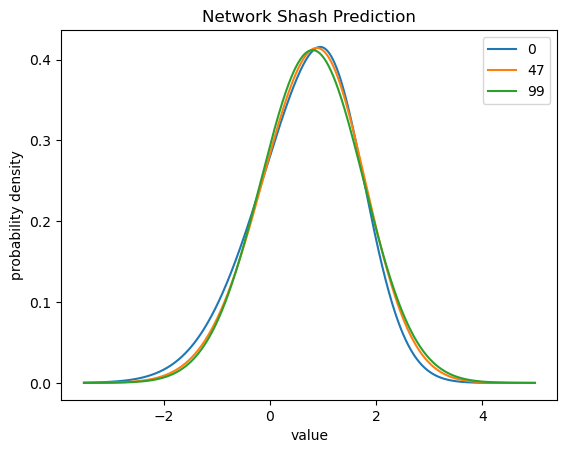

In [6]:
import shash.shash_torch
from shash.shash_torch import Shash

imp.reload(shash.shash_torch)

x = np.arange(-3.5, 5, 0.01)
dist = Shash(output)
p = dist.prob(x).numpy()

samples = [0, 47, 99]
plt.plot(x, p[:,samples], label=samples)
plt.xlabel("value")
plt.ylabel("probability density")
plt.title('Network Shash Prediction')
plt.legend()
plt.show()